# Etude de la détection automatique de caractéristiques sur un signal audio
![ISEN Lille](src/isen.jpg)



Référents :
* A. Frappé 
* A. Gonzalez
* B. Larras

Projet M1 réalisé par :
* J. Le Bellego
* S. Lecoq

# Mise en place

Ce notebook [Jupyter](http://jupyter.org/) se compose de deux types de cellules :

- Celles contenant du **code Python** peuvent être exécuté en appuyant sur simultanément sur les touches *Maj + Entrée*.  
- Celles contenant du **rendu** ou du **markdown** n'ont aucun effet particulier en dehors de contenir du texte.

Le code est prévu pour être exécuté au moins une fois dans l'ordre afin de pouvoir définir tous les éléments, après quoi il vous est possible d'éditer et d'exécutez une celulle en particulier. Toutefois, il est recommandé d'utiliser le fichier **Tests** pour faciliter les tests étant donné que dans ce fichier les fonctions sont initialisées au fur et à mesure.

### Initialisation et dépendances 
Etape intermédiaire consistant à importer les bibliothèques et à configurer le Notebook.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%run -i bin/imports.py

In [2]:
%%html
<script>
IPython.OutputArea.prototype._should_scroll = lines => { return false }  
</script>
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar { display: none; }
.ui-resizable { pointer-events:none; }
.output_stderr { display:none; }
</style>

# Propriétés du fichier audio

La source du fichier audio qui sera utilisée par la démo peut être configurée dans la cellule ci-dessous.
Notez que seul le format **.wav** (audio mono 16 bits) est supporté à l'heure actuelle.

In [3]:
# Source
file = "src/test2.wav"

La cellule ci-dessous charge le fichier audio se trouvant dans le chemin indiqué et définit automatiquement les paramètres suivant :
* **y** : Signal d'entrée
* **fs** : Fréquence d'échantillonage du signal
* **N** : Nombre de points échantillonés
* **t** : Points temporels

In [4]:
# Lecture du fichier audio
fs, y = sw.read(file)
# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

Vous pouvez écouter le fichier chargé ci-dessous :

In [5]:
ipd.Audio(data=y, rate=fs)

### Spectre d'amplitude

Celui-ci représente l'amplitude relative des impulsions sonores (en ordonnée) selon le temps (en abscisse).

Il est affiché par la fonction [**plot_specamp(y, t, ax=None, title="Piste audio", color="darkblue")**](https://github.com/lowlighter/sound/blob/master/bin/plot_specamp.py).

ERROR:root:File `'bin/play_button.py'` not found.


<IPython.core.display.Javascript object>


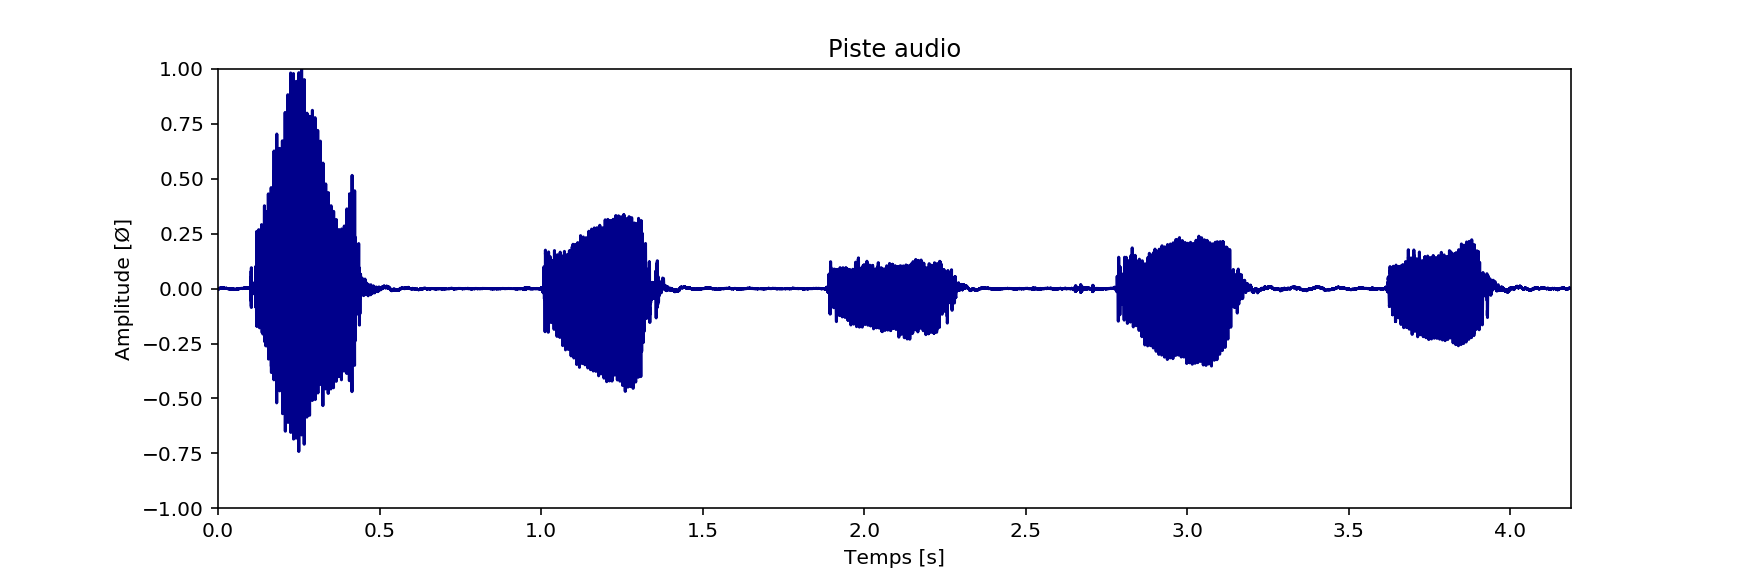

In [6]:
%run -i bin/plot_specamp.py
%run -i bin/play_button.py
plot_specamp(y/max(abs(y)), t)

### Utilisation d'un compresseur audio

Pour étudier un fichier audio, on utilise généralement son apmplitude maximum comme référence comme ci-dessus. Cependant, l'échelle peut facilement être faussée si le volume change brusquement. 

L'utilisation d'un compresseur audio (Dynamic Range Compressor) permet d'amplifier les valeurs en dessous d'un certain seuil bas, et d'atténuer les valeurs au dessus d'un certain seuil haut.

La fonction [**drc(y, tl=False, th=False, ratio=1)**](https://github.com/lowlighter/sound/blob/master/bin/drc.py) définit cette opération.

Il est préférable d'utiliser uniquement le seuil haut puisque l'utilisation du seuil bas risque d'amplifier également les bruits.

Voici donc le fichier ci-dessus après compression audio :

<IPython.core.display.Javascript object>


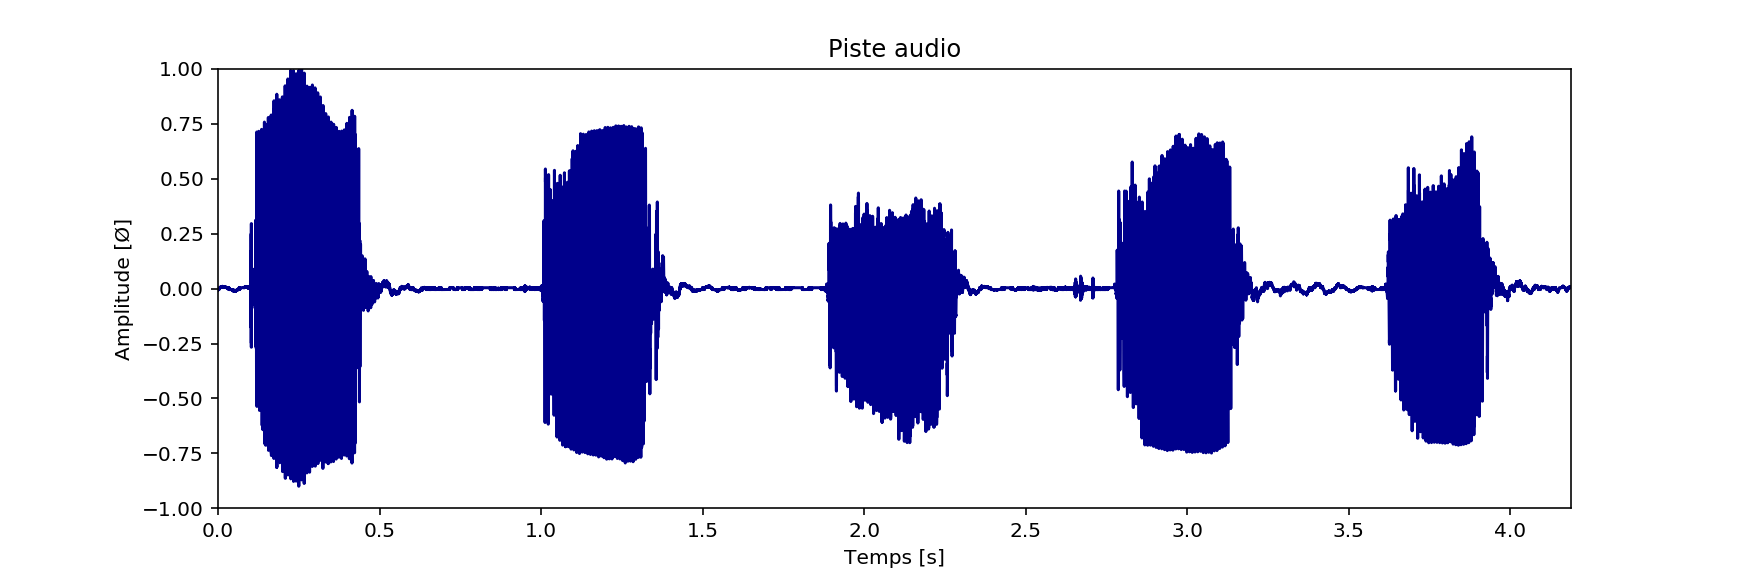

In [7]:
%run -i bin/drc.py
cy = drc(y, tl=10, th=1500, ratio=1/8)
plot_specamp(cy/max(abs(cy)), t)

La fonction [**drcz(tl=False, th=False, ratio=1, ax=None, title="Réponse linéaire")**](https://github.com/lowlighter/sound/blob/master/bin/drcz.py) permet d'afficher la réponse en gain d'un compresseur audio :

<IPython.core.display.Javascript object>


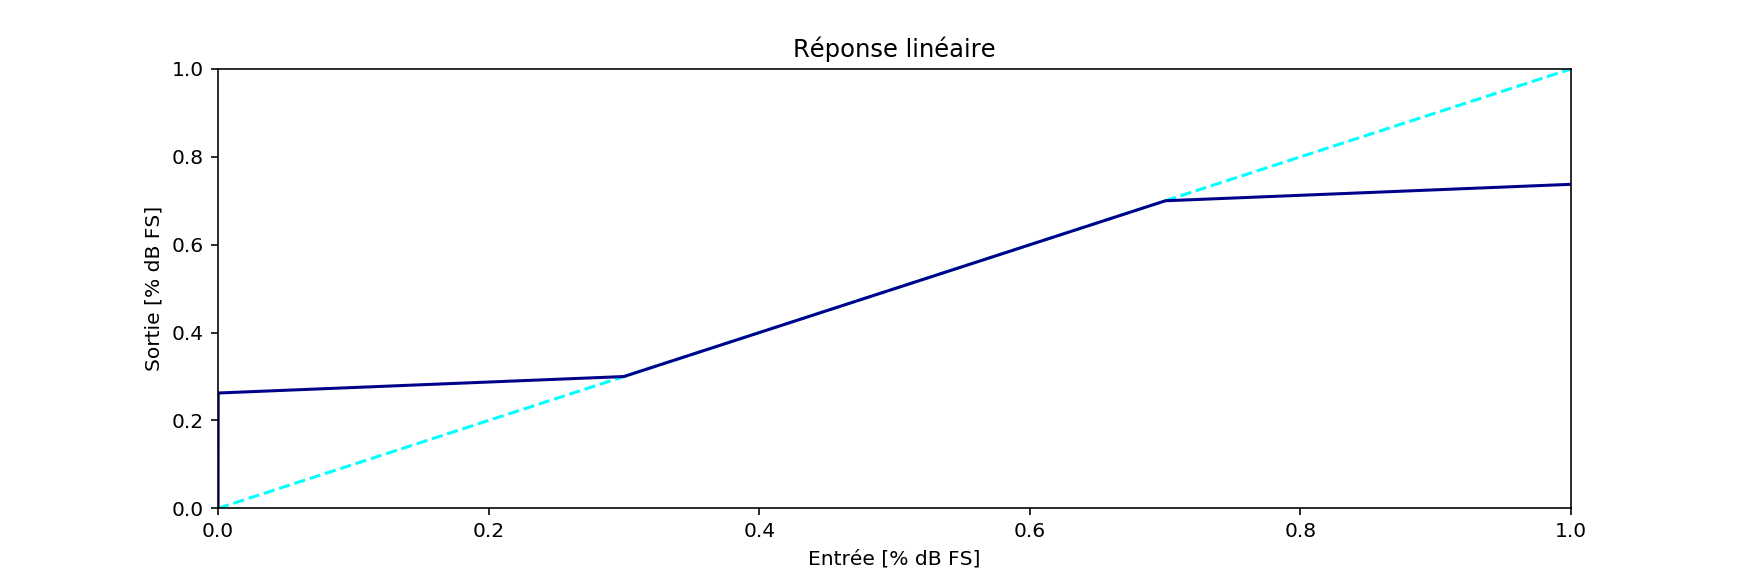

In [8]:
%run -i bin/drcz.py
drcz(tl=0.3, th=0.7, ratio=1/8)

### Spectrogramme

Il représente la densité spectrale de puissance (par nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse). Les couleurs chaudes indiquent une forte énergie tandis que les couleurs froides en montrent l'absence.

Il est affiché par la fonction [**plot_specgram(y, t, fs, ax=None)**](https://github.com/lowlighter/sound/blob/master/bin/plot_specgram.py).

<IPython.core.display.Javascript object>


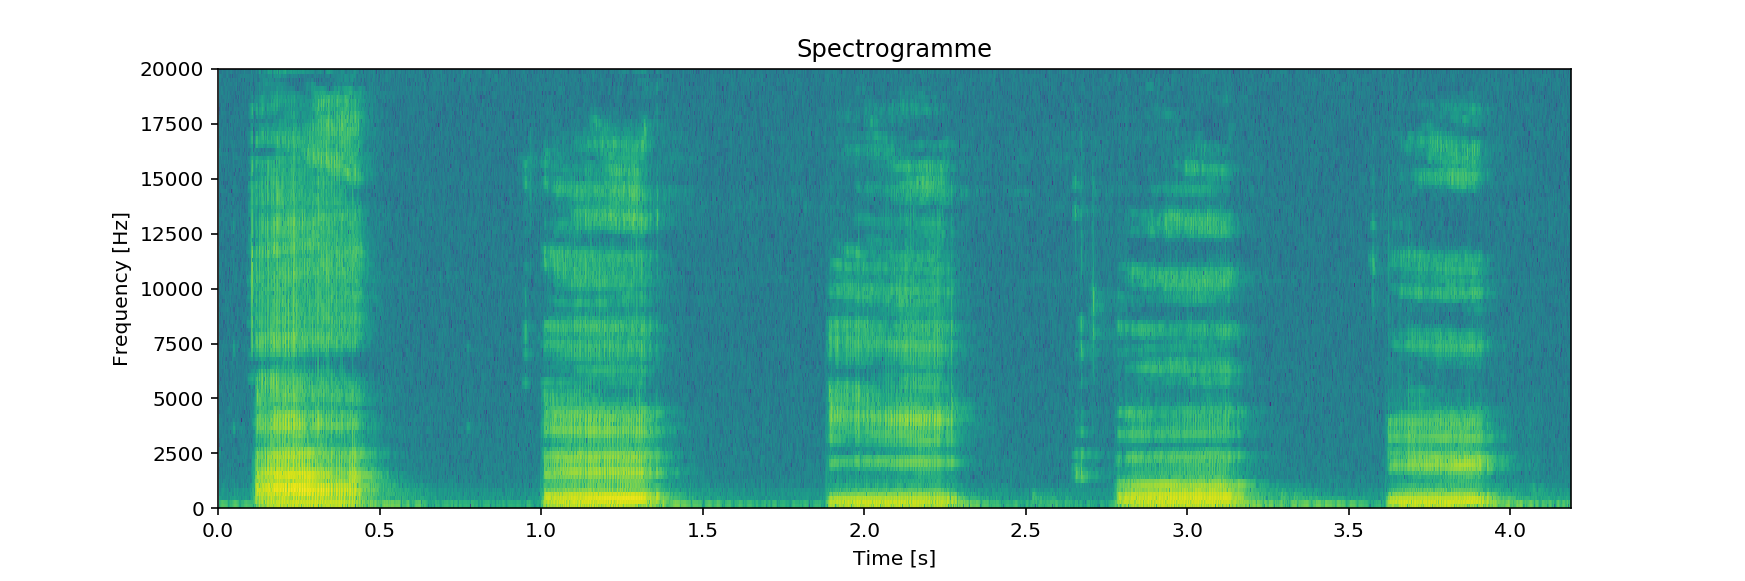

In [9]:
%run -i bin/plot_specgram.py
plot_specgram(y, t, fs)

### Spectre en dB Full Scale

Les fichiers audios sous le format **.wav** utilisent une échelle nommée le **dB FS**. 
Il s'agit du rapport logarithmique entre l'amplitude du signal et la plus grande amplitude que le canal digital puisse représenter.

Par exemple, pour un fichier où les données sont codées sur des entiers signés de 16 bits, la valeur de référence est soit -32 768 ou +32 767.

Le niveau en dB FS est toujours négatif puisque la valeur de référence ne peut théoriquement jamais être dépasée.

Il est affiché par la fonction [**plot_dbfs(y, t, ax=None, title="Piste audio", color="green")**](https://github.com/lowlighter/sound/blob/master/bin/plot_dbfs.py).

<IPython.core.display.Javascript object>


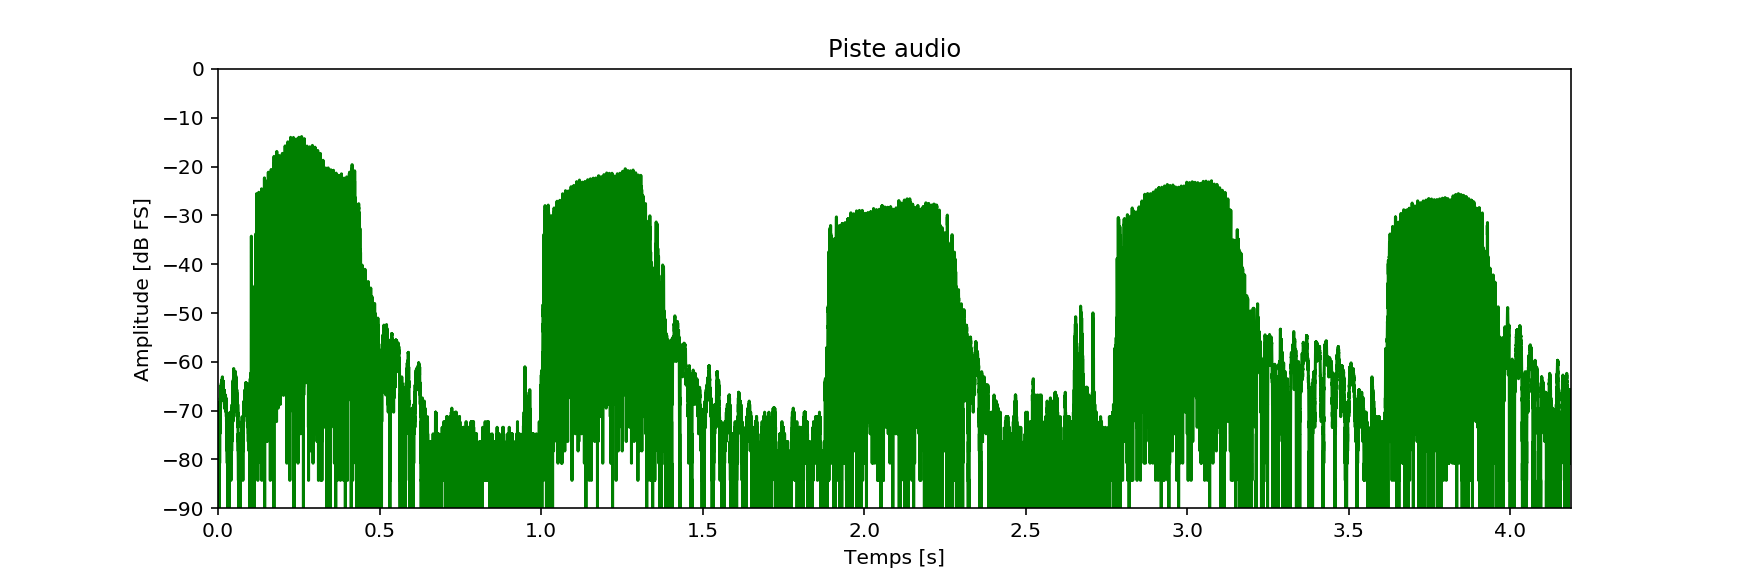

bin/plot_dbfs.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t, 20*np.log10(abs(np.array(y))/32767), color=color)


In [10]:
%run -i bin/plot_dbfs.py
plot_dbfs(y, t)

# Banque de filtres

Dans cette seconde partie, nous allons nous intéresser à la création d'une banque de filtres.

On caractérise celle-ci par ces différents paramètres :
* **fmin** : Fréquence centrale minimum
* **fmax** : Fréquence centrale maximum
* **nb_filters** : Nombre de filtres
* **n** : Ordre des filtres
* **q** : Facteur qualité

Ainsi que les paramètres de génération des spectrogrammes :
* **time_res** : Résolution temporelle (en secondes)
* **amp_res** : Résolution d'amplitude (nombre de bits pour stocker l'amplitude de l'énergie)

In [11]:
# Fréquence centrale minimale
fmin = 300
# Fréquence centrale maximale
fmax = 3000
# Nombre de filtres
nb_filters = 16

# Ordre des filtres
n = 3
# Facteur de qualité
q = 10

# Résolution temporelle des spectrogrammes
time_res = 0.1
# Nombre de bits à utiliser pour pour stocker l'amplitude de l'énergie
amp_res = 4

# Echelle à utiliser
scale = "log"

### Génération de la banque de filtres
Etape intermédiaire qui consiste à générer les différents filtres de la banque en fonction des paramètres ci-dessus.

La banque est générée à l'aide de la fonction [**gen_filters(q, n, fs, nb_filters=12, fmin=20, fmax=20000, fcs=[], debug=False, scale="log")**](https://github.com/lowlighter/sound/blob/master/bin/gen_filters.py) qui effectue plusieurs appels à la fonction [**bandpass(fc, q, n, fs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/bandpass.py).

Il est également possible de générer une liste de filtres avec des fréquences centrales personnalisées de cette façon : **gen_filters(q, n, fs, fcs=[fc1, fc2, ..., fc3], debug=False, scale="log")**.

Lorsqu'aucune liste de fréquence centrale n'est précisé, la fonction générera automatiquement des fréquences centrales situées entre une fréquence min. et max., selon une échelle logarithmique ou de Mel.

In [12]:
%run -i bin/bandpass.py
%run -i bin/gen_filters.py
filters, filters_fq = gen_filters(q, n, fs, nb_filters=nb_filters, fmin=fmin, fmax=fmax, debug=True, scale=scale)

Fc :  300Hz ( 285Hz -  315Hz)
Fc :  349Hz ( 332Hz -  367Hz)
Fc :  407Hz ( 387Hz -  428Hz)
Fc :  475Hz ( 451Hz -  499Hz)
Fc :  554Hz ( 526Hz -  582Hz)
Fc :  646Hz ( 614Hz -  678Hz)
Fc :  753Hz ( 715Hz -  791Hz)
Fc :  878Hz ( 834Hz -  922Hz)
Fc : 1024Hz ( 973Hz - 1075Hz)
Fc : 1194Hz (1134Hz - 1254Hz)
Fc : 1392Hz (1322Hz - 1462Hz)
Fc : 1623Hz (1542Hz - 1704Hz)
Fc : 1892Hz (1798Hz - 1987Hz)
Fc : 2206Hz (2096Hz - 2317Hz)
Fc : 2573Hz (2444Hz - 2701Hz)
Fc : 3000Hz (2850Hz - 3150Hz)


### Réponse fréquentielle de la banque de filtres

Le graphique logarithmique ci-dessous affiche les réponses fréquentielle de chaque filtre de la banque sur la plage des sons audibles par l'oreille humaine (20Hz à 20kHz).

Il est affiché par la fonction [**plot_freqz(filters)**](https://github.com/lowlighter/sound/blob/master/bin/plot_freqz.py).

<IPython.core.display.Javascript object>


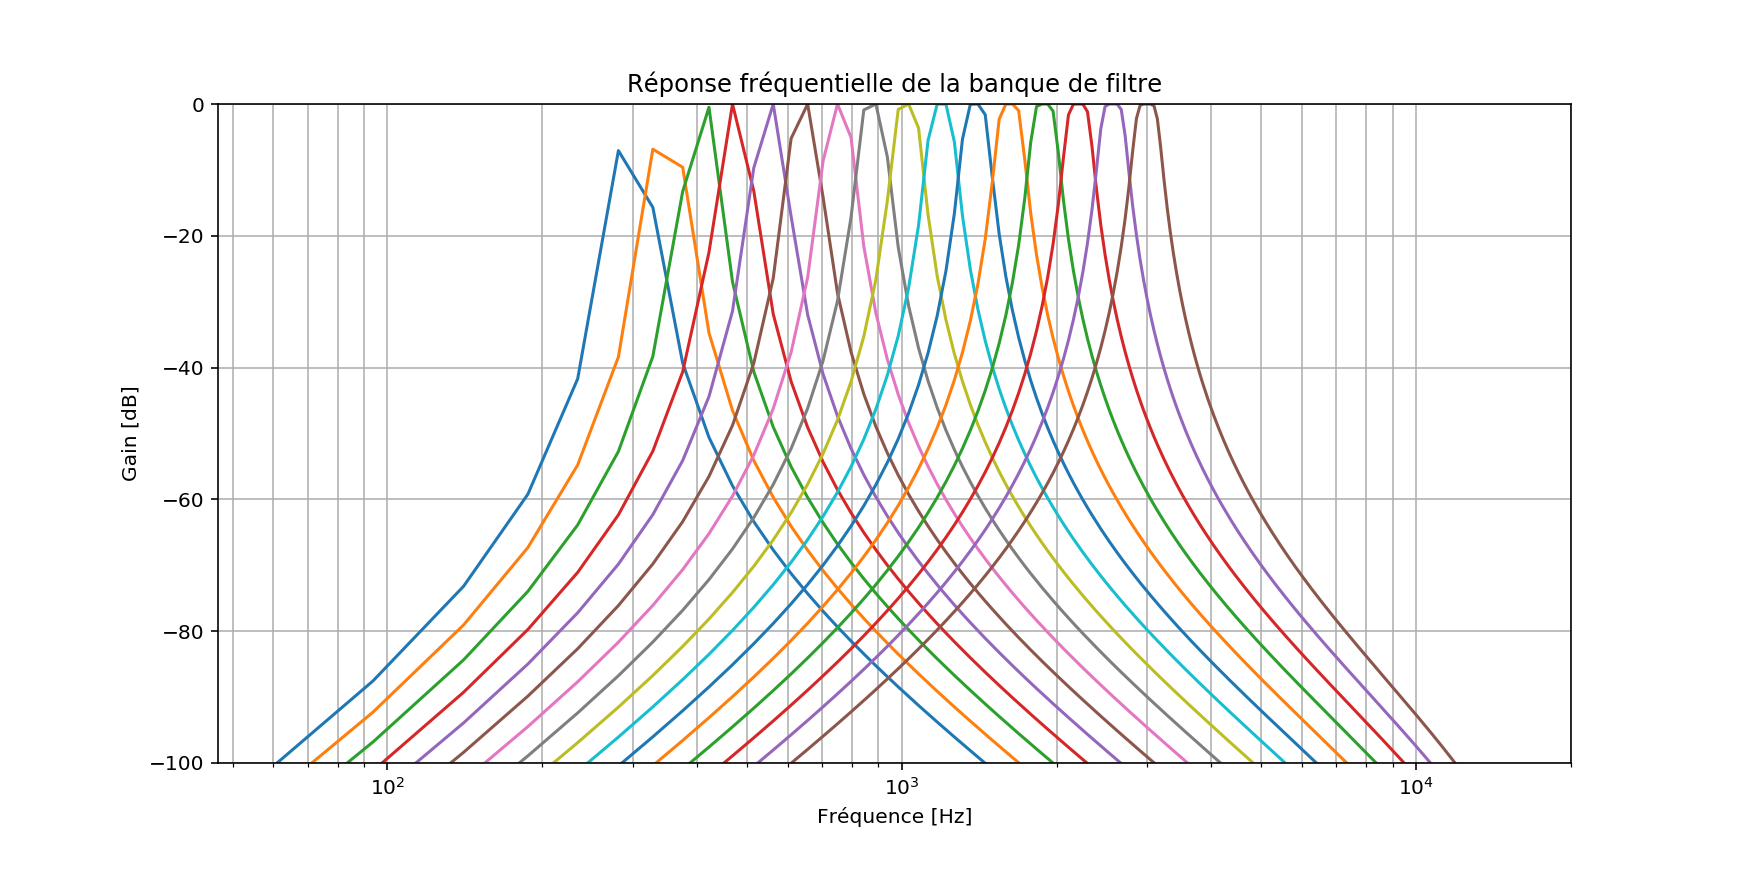

bin/plot_freqz.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));


In [13]:
%run -i bin/plot_freqz.py
plot_freqz(filters)

### Application de la banque de filtres

Une étape intermédiaire qui consiste à appliquer les différents filtres sur le signal d'entrée.

Les signaux après filtrages sont générés par la fonction [**gen_filtered(y, fs, filters)**](https://github.com/lowlighter/sound/blob/master/bin/gen_filtered.py) et l'affichage des signaux filtrés est réalisé par [**plot_filtered(y, t, filtered, filters_fq, nsub=4)**](https://github.com/lowlighter/sound/blob/master/bin/plot_filtered.py).

Le bleu marine représente le signal filtré et le bleu aquatique le signal d'origine.

<IPython.core.display.Javascript object>


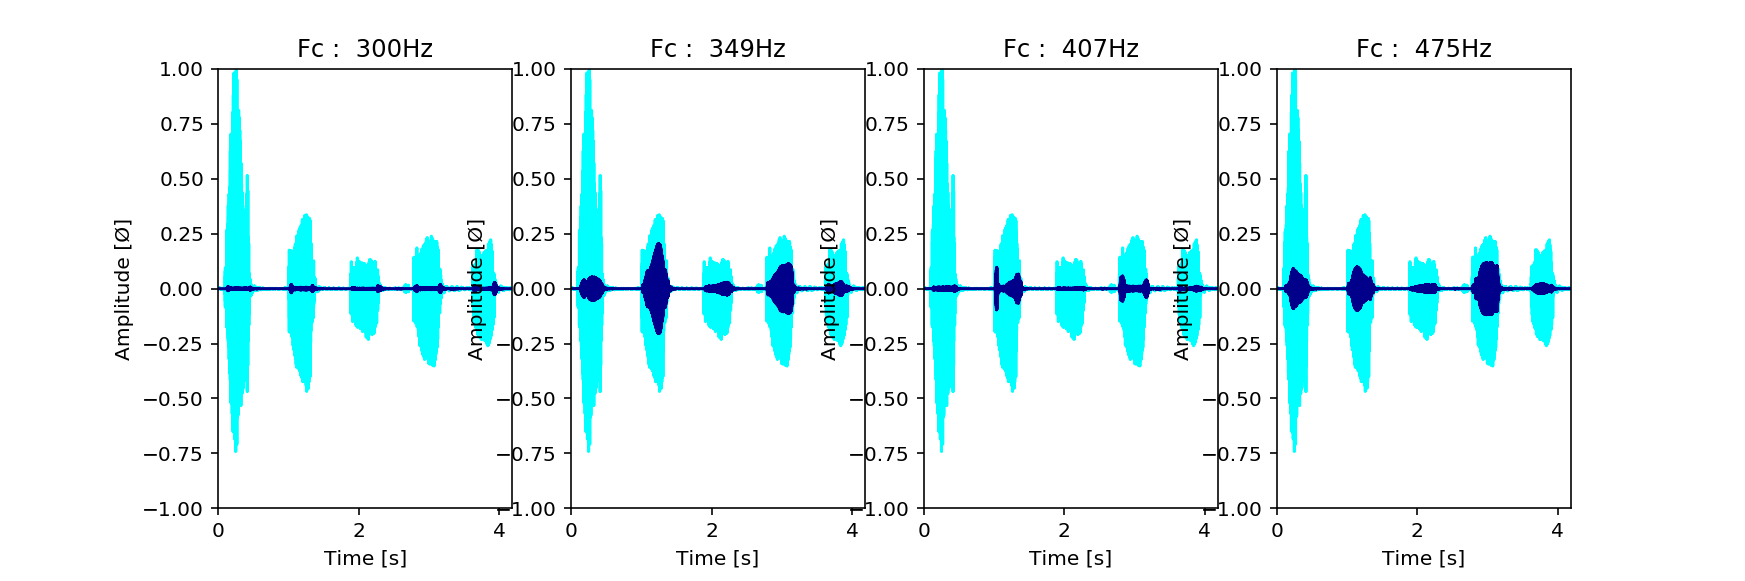

<IPython.core.display.Javascript object>


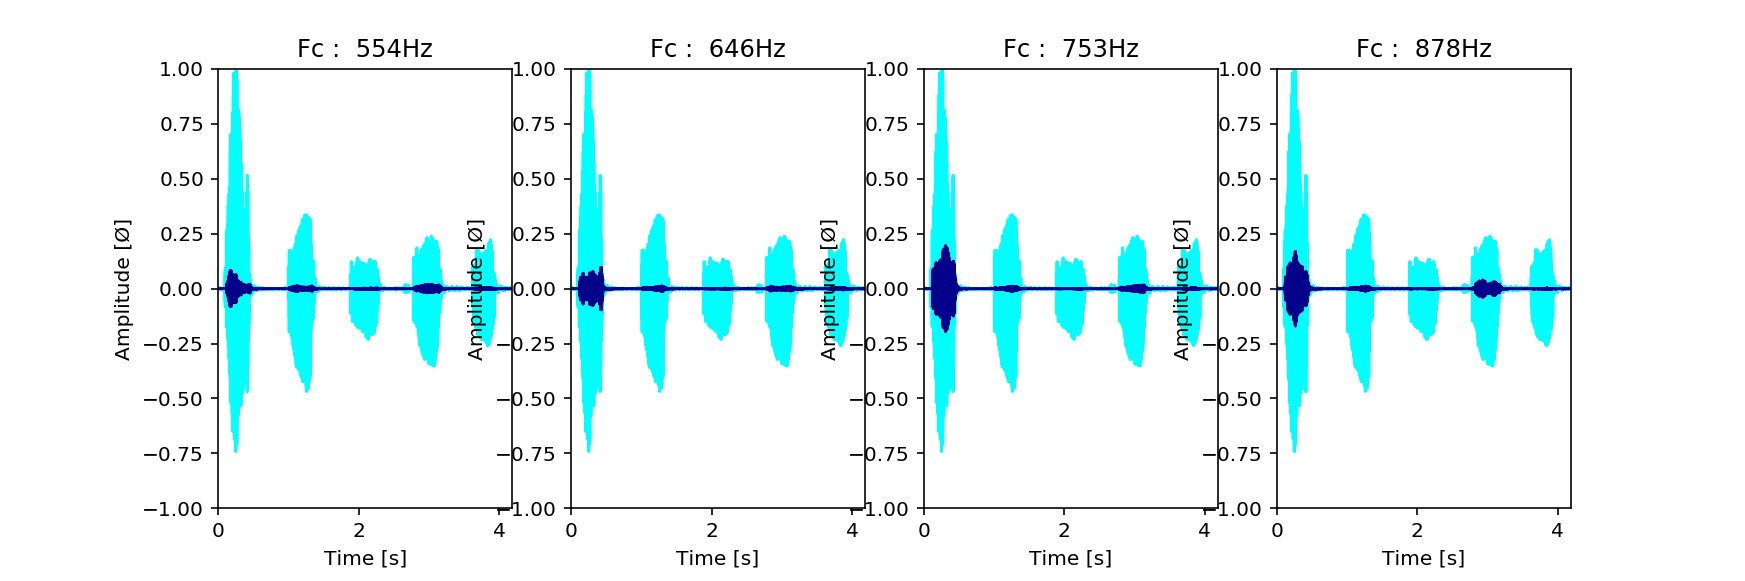

<IPython.core.display.Javascript object>


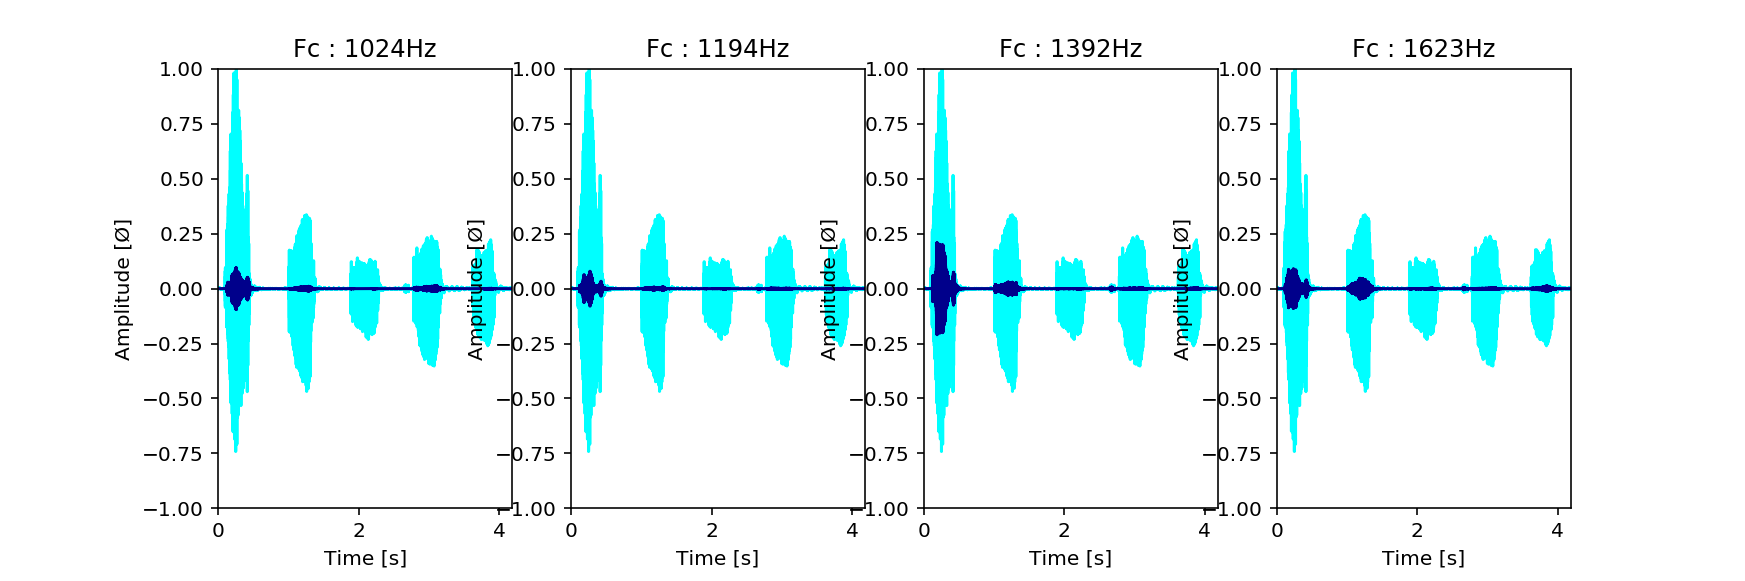

<IPython.core.display.Javascript object>


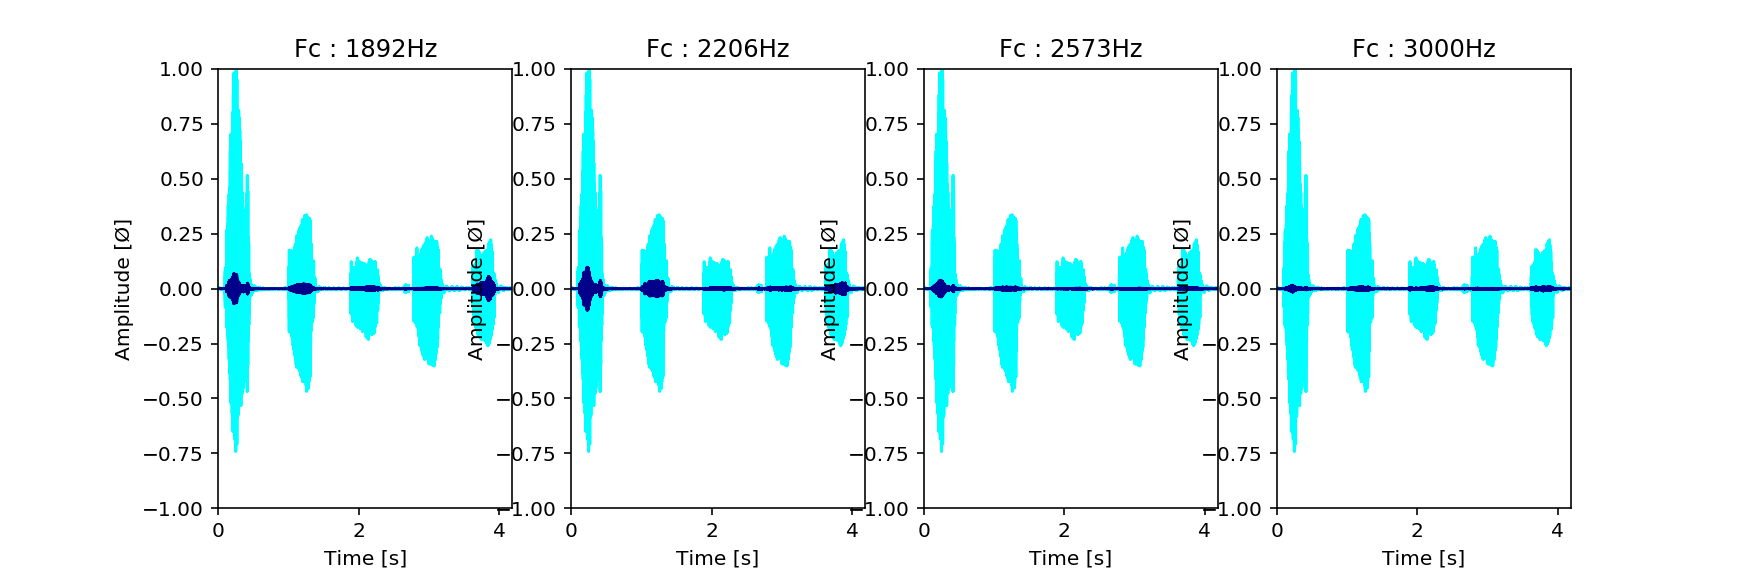

In [14]:
%run -i bin/gen_filtered.py
%run -i bin/plot_filtered.py
filtered = gen_filtered(y, fs, filters)
plot_filtered(y, t, filtered, filters_fq)

# Etude de l'énergie d'un signal en sortie de la banque
Cette partie permet de définir les fonctions qui permettent de calculer l'énergie d'un signal en sortie de la banque.

La fonction [**energies(signal, fs, dt, bits=False)**](https://github.com/lowlighter/sound/blob/master/bin/energies.py) permet de calculer l'énergie contenue dans un signal segmenté par une certaine résolution temporelle **dt**. Elle effectue de multiples appels à la fonction [**energy(signal, fs, start=0, end=False)**](https://github.com/lowlighter/sound/blob/master/bin/energy.py).

Il est possible d'afficher ces résulats en appelant directement la fonction [**plot_energies(signal, fs, dt, bits)**](https://github.com/lowlighter/sound/blob/master/bin/plot_energies.py).

Attention à ne pas utiliser un pas **dt** qui ne pourrait pas être satisfait par la fréquence d'échantillonnage **fs** !

<IPython.core.display.Javascript object>


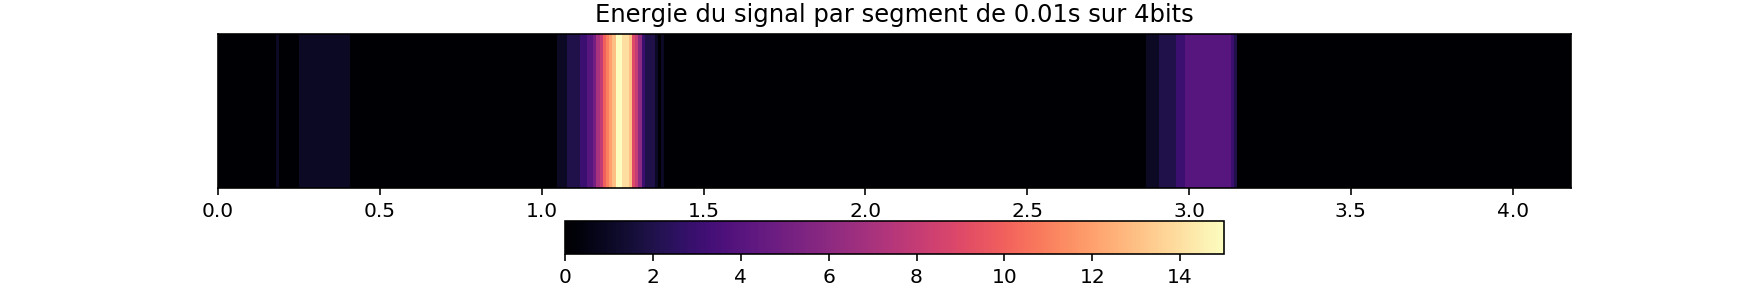

In [15]:
%run -i bin/energy.py
%run -i bin/energies.py
%run -i bin/plot_energies.py
plot_energies(filtered[1], fs, 0.01, bits=amp_res)


# Etude de l'énergie des signaux en sortie de la banque
Cette partie affiche le signal audio en sortie, le spectrogramme associé ainsi que les états après chaque application respective des filtres de la banque.

Les données du spectrogramme sont calculés par la fonction [**gen_data(filtered, fs, time_res, amp_res, filters_fq)**](https://github.com/lowlighter/sound/blob/master/bin/gen_data.py) puis affichées par la fonction [**plot_data(y, t, rsegs, rfreqs, rseqs, ax=None, xlim=False, dbfs=True, formants=[])**](https://github.com/lowlighter/sound/blob/master/bin/plot_data.py).

Ces données sont très similaire à une FFT, mais elles sont calculées selon des une plage de fréquence, une résolution temporelle et d'amplitude définies par l'utilisateur.

<IPython.core.display.Javascript object>


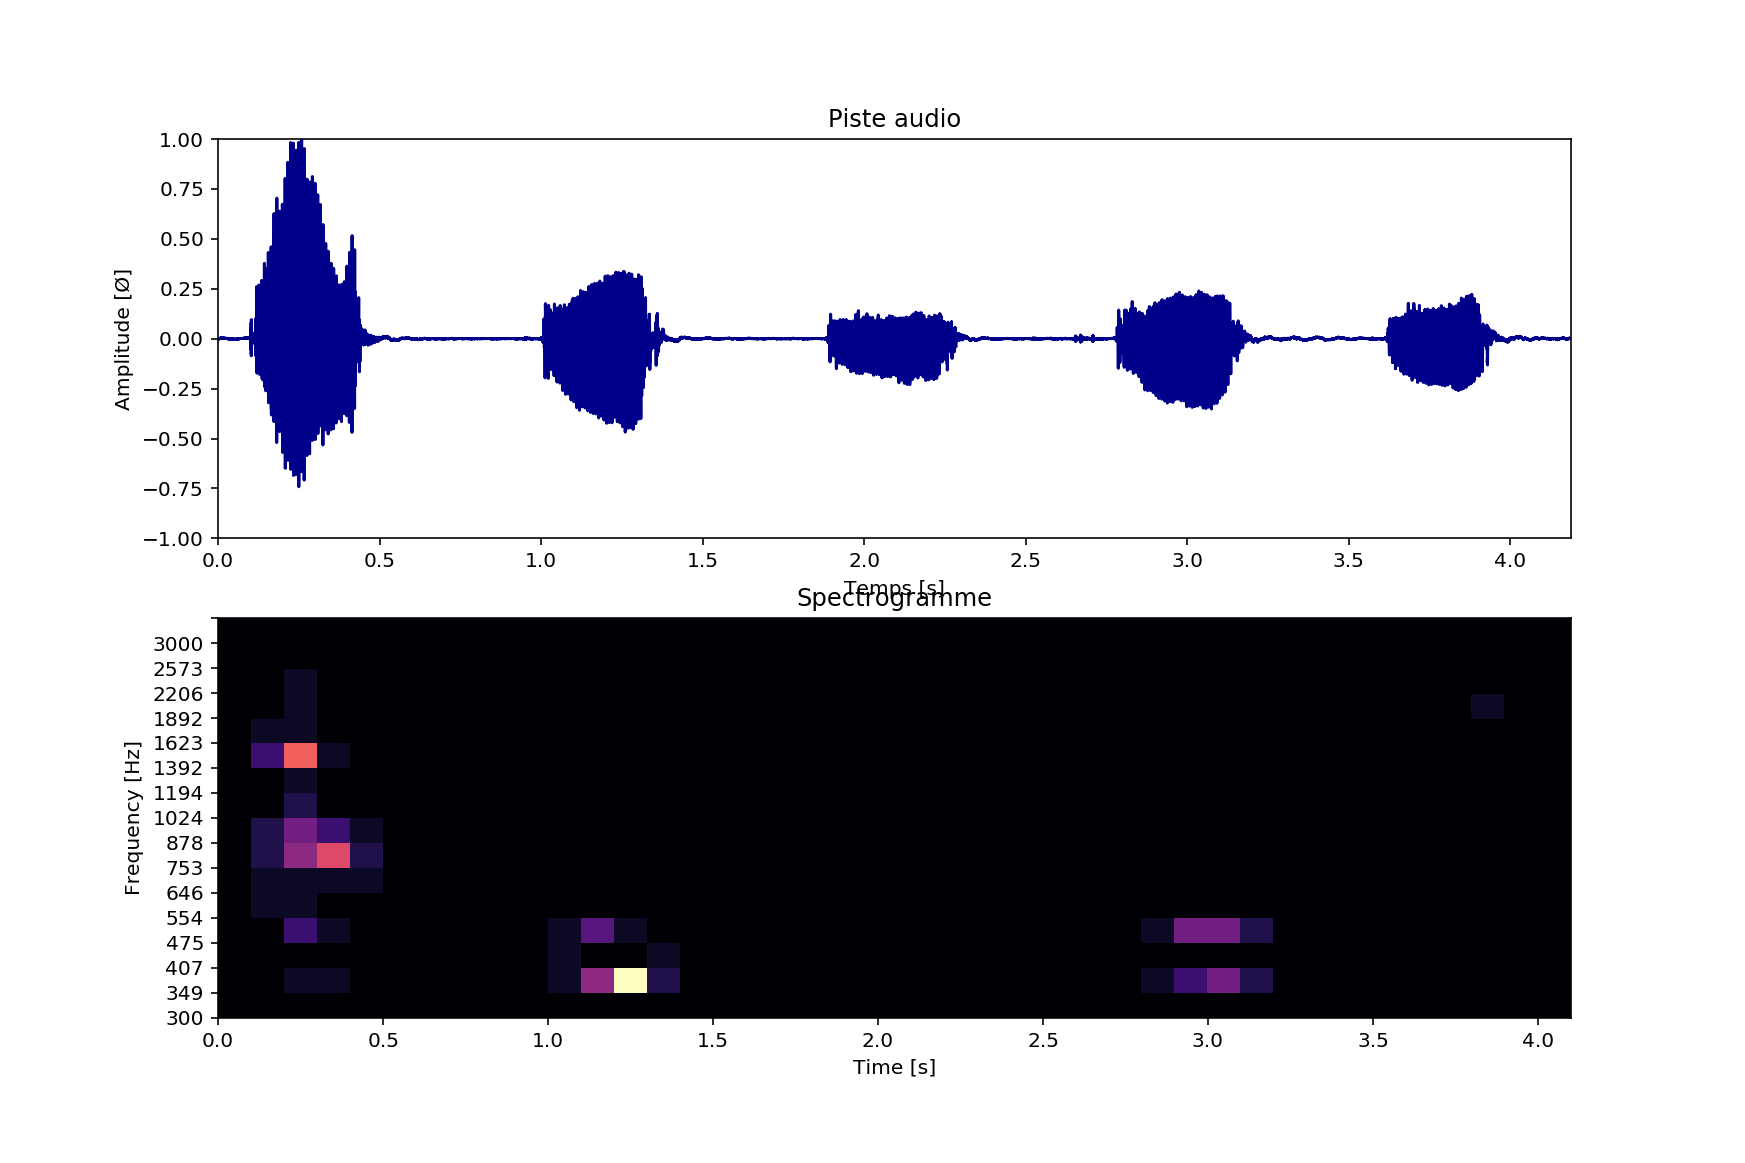

In [16]:
%run -i bin/gen_data.py
%run -i bin/plot_datagram.py
%run -i bin/plot_data.py
%run -i bin/plot_formants.py
rsegs, rfreqs, rseqs = gen_data(filtered, fs, time_res, amp_res, filters_fq)
plot_data(y, t, rsegs, rfreqs, rseqs, dbfs=False)

### Etude des états

Afin de faciliter le traitement des données, il est possible de lire la valeur d'un retournée par l'état d'un filtre à un instant *t* donnée en utilisant la fonction [**state_at(filter_no, s, rsegs, rseqs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/state_at.py).

In [17]:
%run -i bin/state_at.py
print(state_at(math.floor(len(filtered)/2), 0.18, rsegs, rseqs, debug=True))

Valeur numérique du filtre n°8 pour t=0.2s
2.0


Selon la vitesse de prononciation des personnes, il se peut que les coupures spécifiques à un mot ne se produisent pas aux mêmes moments. La fonction [**cut(rseqs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/cut.py). permet découper le résultats en supprimant les zones noires.

In [18]:
%run -i bin/cut.py
cut(rseqs, debug=True);

4 parties différentes :
    0 : Largeur 4
    1 : Largeur 4
    2 : Largeur 4
    3 : Largeur 1


# Récapitulatif

Il est possible d'exécuter toutes les fonctions ci-dessus avec la fonction : 

[**compute(file, fs=0, time_res=0, amp_res=0, fmin=0, fmax=0, fcs=[], nb_filters=0, q=0, n=0, filters=[], filters_fq=[], ax=None, plotd=True, dbfs=True, spec_only=False, spec_xlim=False, drc_tl=False, drc_th=False, drc_r=False, formants=[])**](https://github.com/lowlighter/sound/blob/master/bin/compute.py)

Afin de réduire les temps de calculs, il est possible d'exécuter cette fonction de différentes façons.

### **Sélection de la source**
* **file** : Source du fichier à ouvrir (string)

OU

**file** : Tableau contenant la source du fichier à ouvrir et d'autres références vers des sources de bruits

OU 

* **file** : Signal d'entrée (liste d'amplitudes)
* **fs** : Fréquence d'échantillonage

### **Sélection de la banque de filtres**
* **filters** : Banque de filtre déjà généré (permet d'éviter de les regénérer à chaque fois)
* **filters_fq** : Données caractéristiques des filtres déjà générés

OU

* **fmin** : Fréquence minimum
* **fmax** : Fréquence maximum
* **nb_filters** : Nombre de filtres
* **q** : Facteur de qualité
* **n** : Ordre du filtre

OU

* **fcs** : Liste de fréquences centrales personnalisées
* **q** : Facteur de qualité
* **n** : Ordre du filtre

### **Configuration du spectrogramme**
* **time_res** : Résolution temporelle
* **amp_res** : Résolution en amplitude
* **spec_only** : Afficher uniquement le spectrogramme (indiquer le titre)  
* **spec_xlim** : Limite en abscisse du spectrogramme

### **Utilisation d'une figure déjà existante**
* **f** : Figure contenant ax (laisser vide si le paramètre ax n'est pas spécifié)
* **ax** : Surface de dessin existante (laisser vide pour créer une nouvelle figure)


### Modification de l'affichage
* **plotd** : Affiche la figure sortante (activé par défaut)
* **spec_only** : Affiche uniquement le spectrogramme
* **spec_xlim** : Modifie les limites de l'axe des abscisses du spectrogramme
* **dbfs** : Affiche le spectre DB FS 
* **formants** : Liste de formants à indiquer sur le schéma (la première valeur doit être un nombre indiquant la tolérance de fréquence par rapport à la valeur de base)

### Compresseur audio
* **drc_tl** : Seuil bas du compresseur audio
* **drc_th** : Seuil haut du compresseur audio
* **drc_r** : Ratio du compresseur audio

Par exemple, pour charger un fichier, générer une banque de filtre et afficher le spectre d'amplitude ainsi que le spectrogramme, il suffit d'écrire :

<IPython.core.display.Javascript object>


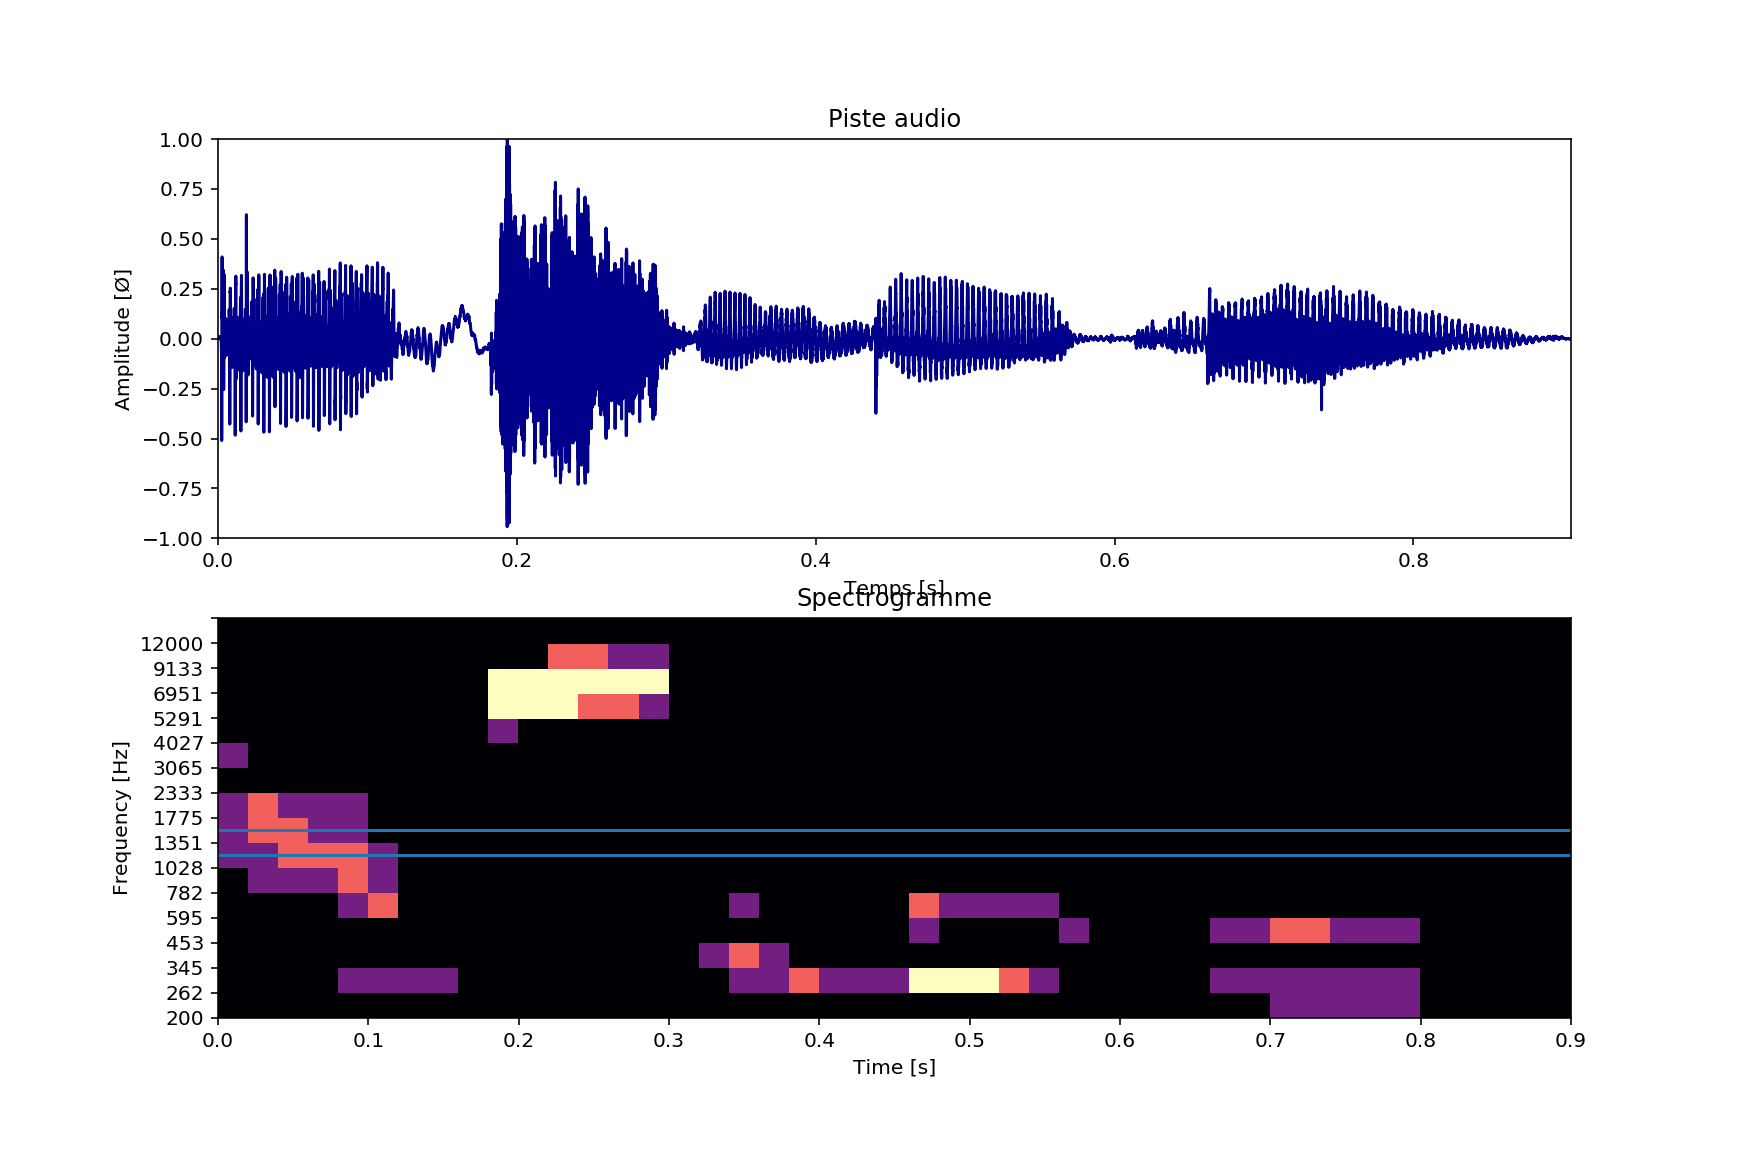

In [19]:
%run -i bin/plot_formants.py
%run -i bin/compute.py
rsegs, rfreqs, rseqs = compute(
    file="src/Words/voice_F1_absolutely_2.wav", 
    fmin=200, 
    fmax=12000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.02, 
    amp_res=2,
    formants=[150, "a"]
);

# Comparaison de plusieurs fichiers audios

La fonction [**compare(files, folder="", format=".wav", time_res=0, amp_res=0, fmin=0, fmax=0, fcs=[], nb_filters=0, q=0, n=0, filters=[], filters_fq=[], plotd=True, drc_tl=False, drc_th=False, drc_r=False, formants=[])**](https://github.com/lowlighter/sound/blob/master/bin/compare.py) est un raccourci de la fonction **compute** qui permet de charger plusieurs fichiers pour pouvoir les comparer.

Par exemple, l'appel à la fonction **compare** ci-dessous permet de visualiser le spectrogramme du mot **together** prononcé par 2 personnes différentes ainsi que le mot **already**.

C:\ProgramUser\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


<IPython.core.display.Javascript object>


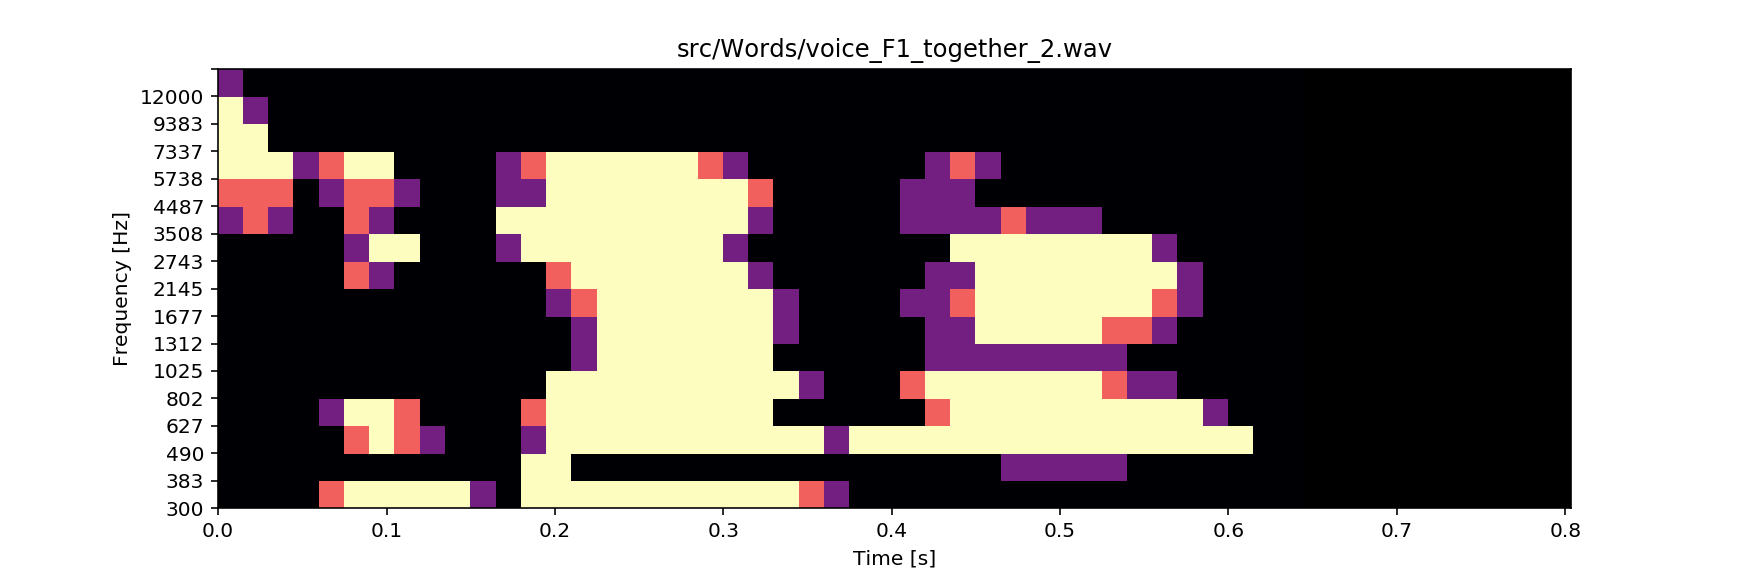

<IPython.core.display.Javascript object>


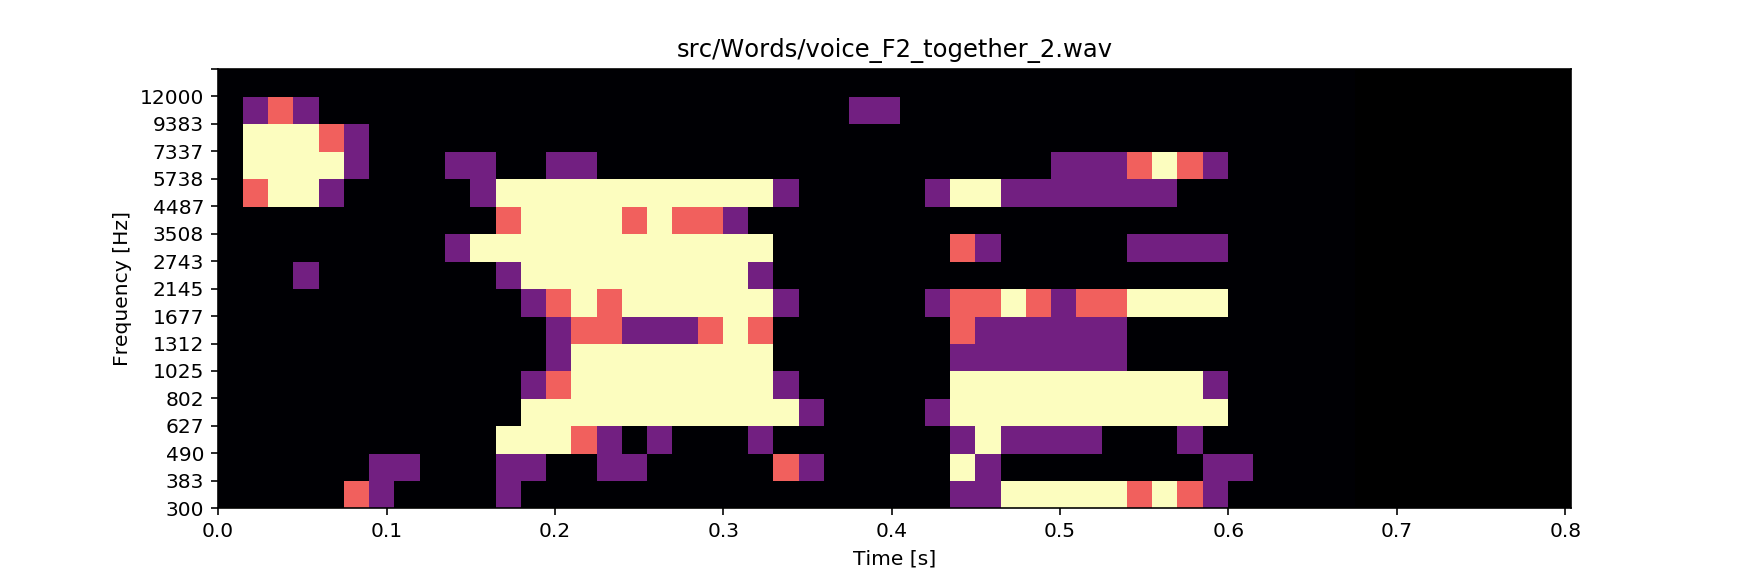

<IPython.core.display.Javascript object>


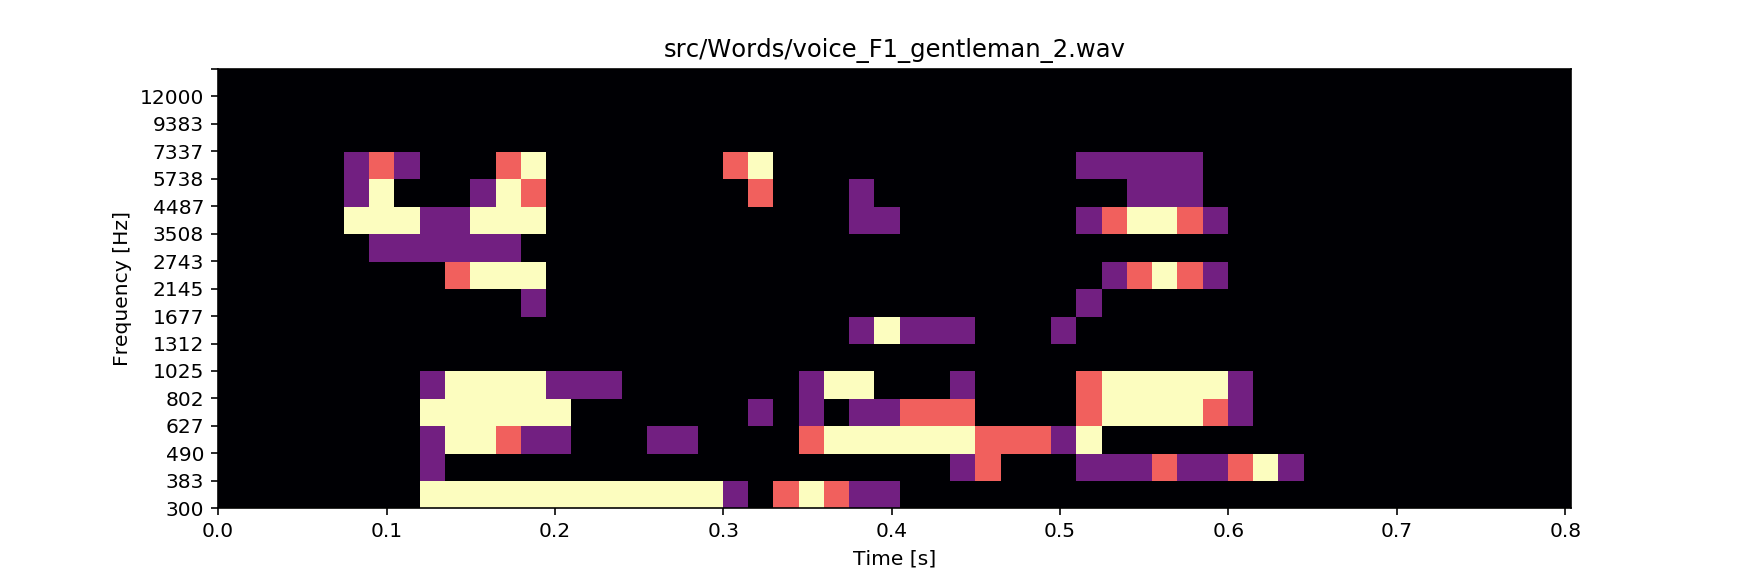

<IPython.core.display.Javascript object>


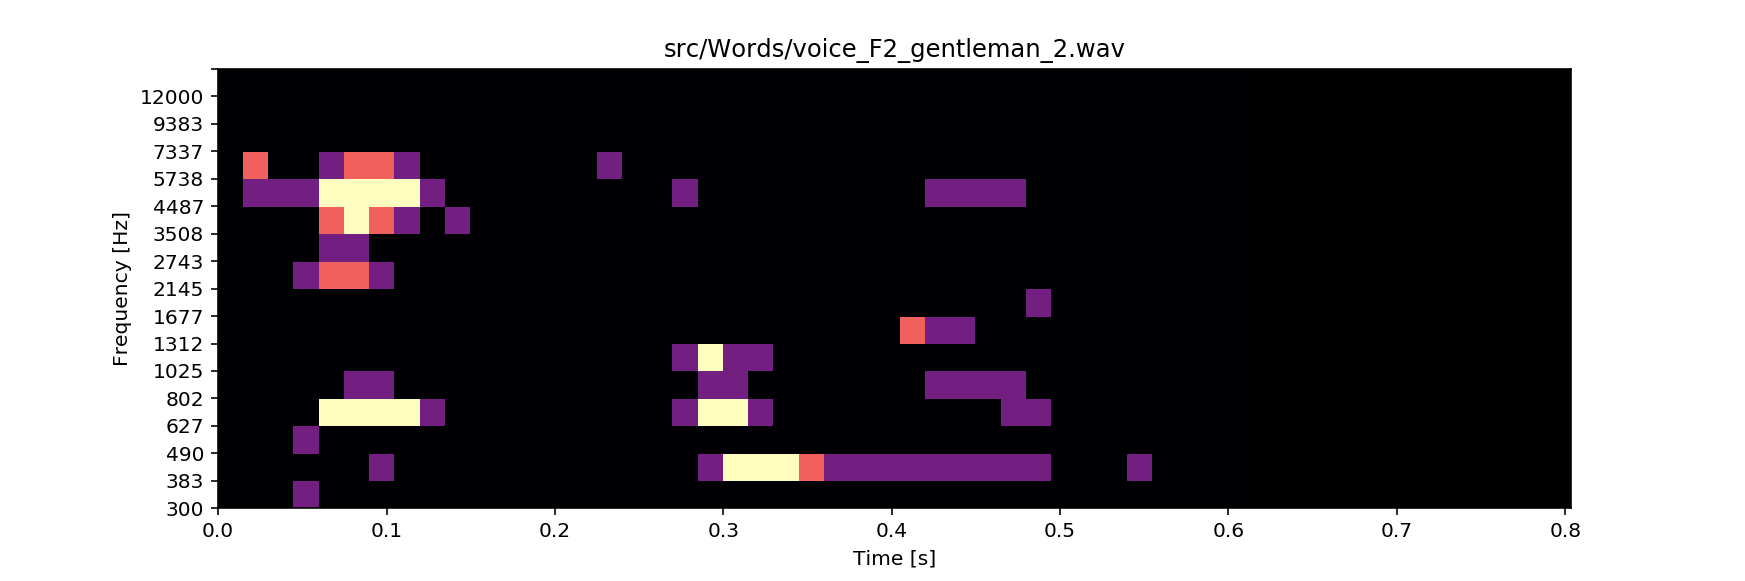

In [20]:
%run -i bin/compare.py
compared = compare(
    folder="src/Words/",
    files=["voice_F1_together_2", "voice_F2_together_2", "voice_F1_gentleman_2", "voice_F2_gentleman_2"],
    fmin=300, 
    fmax=12000, 
    nb_filters=16, 
    q=6, 
    n=3, 
    time_res=0.015, 
    amp_res=2
);

### Première approche
Afin de comparer plusieurs sons pour savoir s'ils sont similaires, une première approche naïve est de calculer la matrice de corrélation entre deux sons différents.

La fonction [**similarities(compared, names)**](https://github.com/lowlighter/sound/blob/master/bin/similarities.py) permet d'effectuer plusieurs appels successif à la fonction [**similar(a, b)**](https://github.com/lowlighter/sound/blob/master/bin/similar.py) afin d'afficher un '**score**' entre deux fichiers. 

En théorie, si deux fichiers sont identiques, le score est de 1, tandis que s'ils sont totalement différents, la limite du score s'approchera de 0.

Toutefois, il est très difficile de se contenter que de ceci, puisqu'en pratique, vous pouvez observer que deux mots identiques bien que possédant des similarités, possèdent des coupures (bandes noirs) et des niveaux d'énegie différents.

Si cette méthode ne semble pas la plus appropriée pour pouvoir vérifier qu'un même mot ait été prononcé, elle semble cependant assez fiable pour déterminer si deux mots sont différents.

In [21]:
%run -i bin/similar.py
%run -i bin/similarities.py

similarities(compared, ["together (F1)", "together (F2)", "gentleman (F1)", "gentleman(F2)"])

together (F1) # together (F2) : 0.6806311216349221
together (F1) # gentleman (F1) : 0.40937565785030006
together (F1) # gentleman(F2) : 0.4405946666716778
---
together (F2) # gentleman (F1) : 0.4271011619485241
together (F2) # gentleman(F2) : 0.45109073842944836
---
gentleman (F1) # gentleman(F2) : 0.5091352971160622


C:\ProgramUser\Anaconda\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramUser\Anaconda\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Vérification des résultats 

Afin de pouvoir vérifier que le spectrogramme fonctionne comme prévu, il est possible de générer un sinus audio [** gen_sine(f=440.0, duration=1.0, volume=1, fs=48000, src_out="src/sine.wav")**](https://github.com/lowlighter/sound/blob/master/bin/gen_sine.py) et de s'assurer que le graphe obtenu est cohérent.

<IPython.core.display.Javascript object>


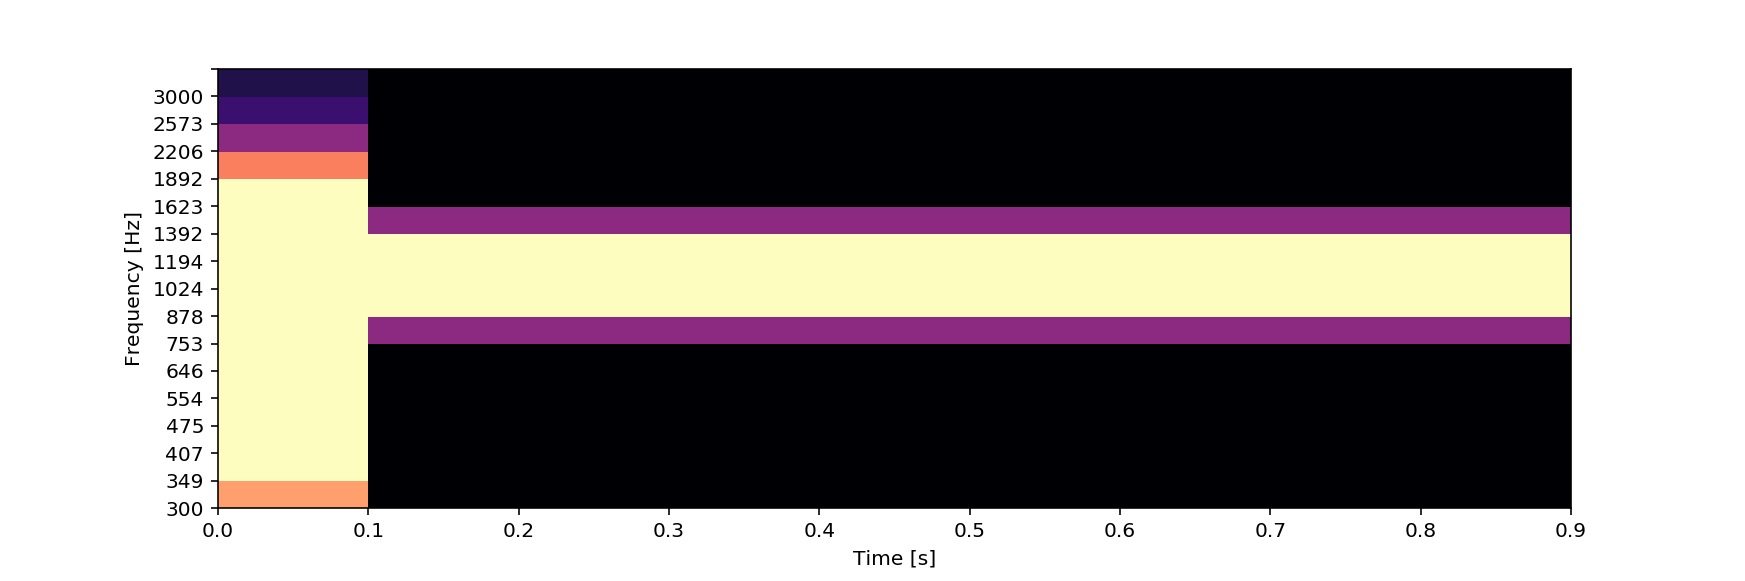

In [22]:
%run -i bin/gen_sine.py
gen_sine(f=filters_fq[int(len(filters_fq)/2)]["fc"], duration=1, fs=fs, src_out="src/sine.wav")
compute(file="src/sine.wav", filters=filters, filters_fq=filters_fq, time_res=time_res, amp_res=amp_res, spec_only=" ");

### Comparaison avec le spectrogramme natif

La fonction [**plot_fft(file, filters_fq, ax=None, title="Spectrogramme", xlim=False, formants=[], drc_tl=False, drc_th=False, drc_r=False)**](https://github.com/lowlighter/sound/blob/master/bin/plot_fft.py) permet d'afficher l'implémentation classique supporté par python, que l'on peut donc comparer avec notre implémentation.

<IPython.core.display.Javascript object>


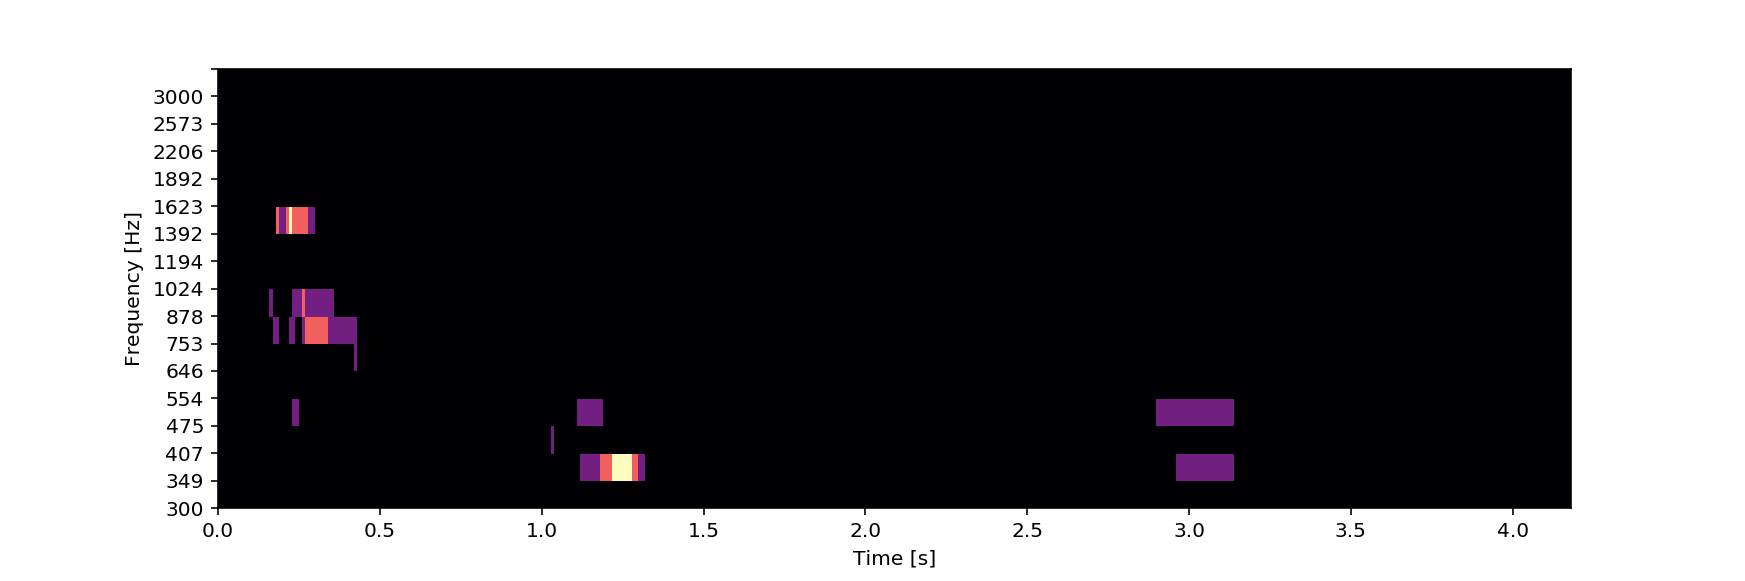

<IPython.core.display.Javascript object>


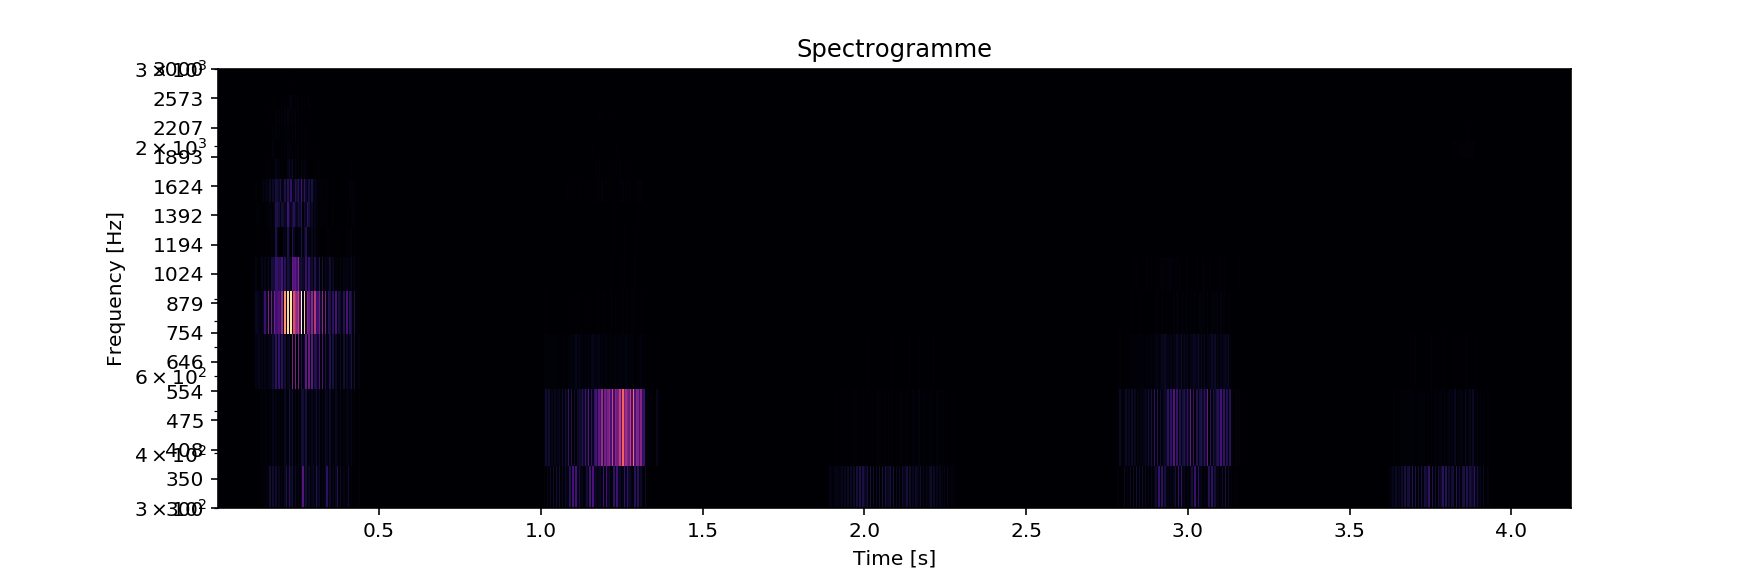

In [23]:
%run -i bin/plot_fft.py
compute(file="src/test2.wav", filters=filters, filters_fq=filters_fq, time_res=0.01, amp_res=2, spec_only=" ");
plot_fft(file="src/test2.wav", filters_fq=filters_fq);

# Traitement à la volée

Si **[pyaudio](https://people.csail.mit.edu/hubert/pyaudio/)** est installé sur votre machine, il est possible d'enregistrer des sons depuis votre microphone et de les traiter au fur et à mesure (avec un léger décalage).

Pour cela, assurer vous de configurer correctement les deux variables suivantes, ce qui permettra d'inclure de nouvelles bibliothèques requises pour faire fonctionner la suite de ce programme.

In [24]:
# Chemin vers les bibliothèques Python
lib_path = "C:\Program Files\Python36\Lib\site-packages"

In [25]:
%run -i bin/imports_pyaudio.py

L'enregistrement est réalisé par la fonction [**live_record()**](https://github.com/lowlighter/sound/blob/master/bin/live_record.py).

Le code suivant permet de commencer un nouvel enregistrement et de traiter en temps réel les données.

Il faut **interrompre** le kernel afin de pouvoir arrêter l'exécution de cette cellule et pouvoir en utiliser d'autres :
![Interruption](src/stop.png)

In [26]:
%run -i bin/live_record.py
filters, filters_fq = gen_filters(fmin=100, fmax=4000, nb_filters=20, q=3, n=3, fs=12000)
live_record(time_res=0.1, amp_res=20, filters_fq=filters_fq, filters=filters, fs=12000, last=2, formants=[200, "a"])

Terminé !
